# Introduction

This notebook aims to explore the data, clean it, visualize it, and offer intuitive conclusions. No model will be created, except for identifying correlations between parameters or response variables. 
This serves as an excellent starting point for those seeking a comprehensive understanding of the data for further analysis or model creation. However check out the summary before reading through as it provides some problems found in the dataset.

---
As a master's student in data science, this is my first contribution to Kaggle. It would make my day if you could give this a **up vote**. All **feedback** for future contributions is highly appreciated..

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
df = pd.read_csv('/kaggle/input/sleep-health-and-lifestyle-dataset/Sleep_health_and_lifestyle_dataset.csv').drop('Person ID',axis=1)

/kaggle/input/sleep-health-and-lifestyle-dataset/Sleep_health_and_lifestyle_dataset.csv


# Simple exploration and visualization of data

In [2]:
df.head(10).style.set_table_styles([
    {'selector': 'th', 'props': [('border', '1px solid #ddd'), ('font-size', '10pt')]},
    {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('font-size', '10pt')]},
    {'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', 'lightsteelblue')]}
])

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,Male,27,Software Engineer,6.100000,6,42,6,Overweight,126/83,77,4200,None
1,Male,28,Doctor,6.200000,6,60,8,Normal,125/80,75,10000,None
2,Male,28,Doctor,6.200000,6,60,8,Normal,125/80,75,10000,None
3,Male,28,Sales Representative,5.900000,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,Male,28,Sales Representative,5.900000,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Software Engineer,5.900000,4,30,8,Obese,140/90,85,3000,Insomnia
6,Male,29,Teacher,6.300000,6,40,7,Obese,140/90,82,3500,Insomnia
7,Male,29,Doctor,7.800000,7,75,6,Normal,120/80,70,8000,None
8,Male,29,Doctor,7.800000,7,75,6,Normal,120/80,70,8000,None
9,Male,29,Doctor,7.800000,7,75,6,Normal,120/80,70,8000,None


In [3]:
missing_data = df.isna().sum()
missing_data_df = pd.DataFrame(missing_data).reset_index()
missing_data_df.columns = ['Column', 'Missing']
missing_data_df

,Column,Missing
0,Gender,0
1,Age,0
2,Occupation,0
3,Sleep Duration,0
4,Quality of Sleep,0
5,Physical Activity Level,0
6,Stress Level,0
7,BMI Category,0
8,Blood Pressure,0
9,Heart Rate,0


Only slight modifications needed

## Numerical

### Fixing the inconsistency in the **Blood pressure** category
Looking at the data the bloodpressure category does not seem to be in a correct format. Changing it into two numeric categores low_pressure and high_pressure.

In [4]:
df["High_pressure"] = 0
df["Low_pressure"] = 0

for i, val in enumerate(df["Blood Pressure"]):
    j = 0
    
    while val[j] != "/":
        j += 1
        continue
        
    df.loc[i, "High_pressure"] = int(val[:j])
    df.loc[i, "Low_pressure"] = int(val[(j+1):])

df.drop("Blood Pressure", axis=1)
print("Successfully created numeric categories Low_pressure and high_pressure, droped Blood pressure")

Successfully created numeric categories Low_pressure and high_pressure, droped Blood pressure


In [5]:
df.describe().style.set_table_styles([
    {'selector': 'th', 'props': [('border', '1px solid #ddd'), ('font-size', '10pt')]},
    {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('font-size', '10pt')]},
    {'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', 'lightsteelblue')]}
])

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,High_pressure,Low_pressure
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920,128.553476,84.649733
std,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679,7.748118,6.161611
min,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000,115.000000,75.000000
25%,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000,125.000000,80.000000
50%,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000,130.000000,85.000000
75%,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000,135.000000,90.000000
max,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000,142.000000,95.000000


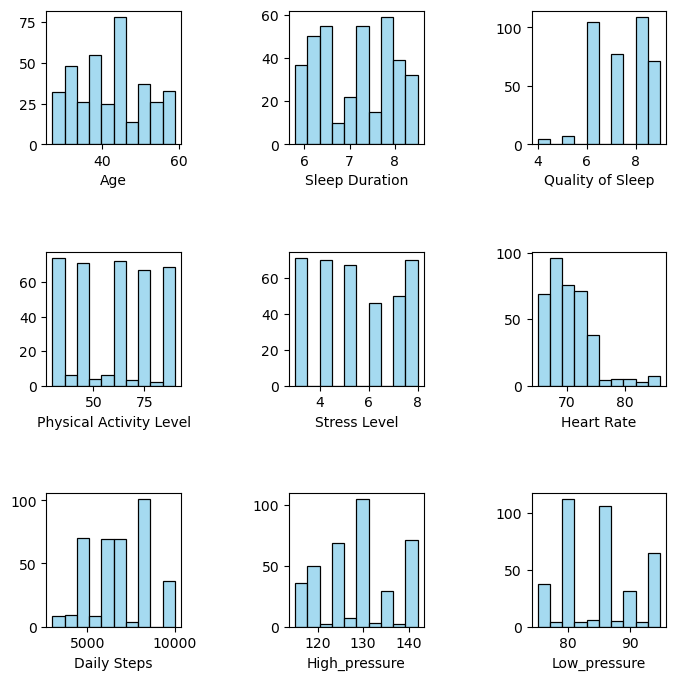

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
plt.subplots_adjust(wspace=0.8, hspace=0.8)

numeric = ["Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Stress Level", "Heart Rate", "Daily Steps", "High_pressure", "Low_pressure"]

for i, cat in enumerate(numeric):
    sns.histplot(df[cat], bins=10, color='skyblue', ax=axs[int(i/3), i%3]).set_ylabel("")    

plt.show()

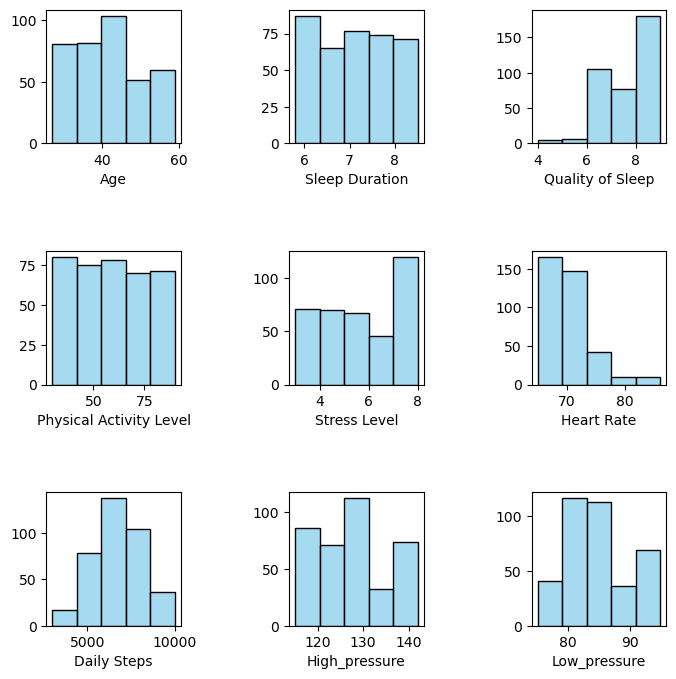

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
plt.subplots_adjust(wspace=0.8, hspace=0.8)

for i, cat in enumerate(numeric):
    sns.histplot(df[cat], bins=5, color='skyblue', ax=axs[int(i/3), i%3]).set_ylabel("")    

plt.show()

### Analysis
- **Quality of Sleep**: Appears to be somewhat exponentially distributed, skewed towards higher values.
- **Age**: Appears to be somewhat normally distributed, no outliers observed.
- **Sleep Duration**: Uniformly distributed.
- **Physical Activity Level**: Uniformly distributed.
- **Stress Level**: The distribution is skewed towards high stress levels.
- **Heart Rate**: Appears to be exponentially distributed, skewed towards lower heart rates.
- **Daily Steps**: Appears somewhat normally distributed within the dataset.
- **High Pressure**: Appears somewhat normally distributed but could conform to another type of distribution.
- **Low Pressure**: Also appears somewhat normally distributed. Interestingly, the distribution between high and low pressure is not identical.

There are **peculiarities** with the quality of sleep, stress level, and physical activity level where they seem to be spaced out (possibly due to issues with the questions asked). The same **sporadic pattern** is observed in blood pressure and steps, which needs further explanation, it will likely provide problem confirming any distributions. No apparent outliers can be detected in the data, and the data appears to be already cleaned. All parameters seem intuitively related to sleep quality. No parameter can be discarded, and hence a subsequent analysis of their statistical relevance is warranted.

## Categorical

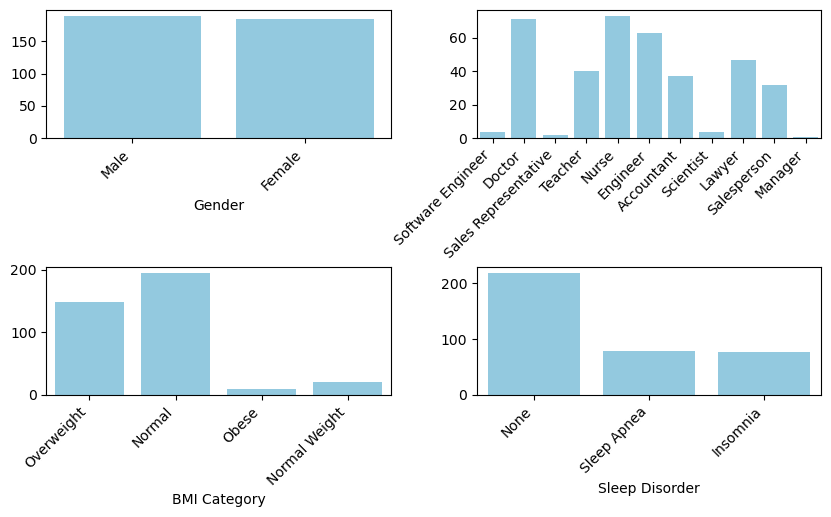

In [8]:
categorical = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']

fig, axs = plt.subplots(2, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.25, hspace=1)

for i, cat in enumerate(categorical):
    sns.countplot(x=cat, data=df, color='skyblue', ax=axs[int(i/2), i%2]).set_ylabel("") 
    plt.xticks(rotation=45) 

for ax in axs.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
#plt.tight_layout()
plt.show()



### Parameters and Analysis

- **Gender (binary-class)**: Displays an even distribution and could influence sleep.
- **Occupation (multi-class)**: Certain occupations do not have sufficient representation to draw any conclusions. One possible approach is to remove all occupations with a count lower than 20 and replace them with an "unknown" class.
- **BMI Category (multi-class)**: There's a balanced distribution between overweight and normal categories. "Normal Weight" appears to be a typo, which will be reclassified as "Normal", and we will add "Obese" to the "Overweight" category because lack of samples.
- **Sleep Disorder (multi-class)**: The distribution is evenly split between individuals with and without sleep disorders, though the disorders themselves are divided between sleep apnea and insomnia. This might be a potential response variable.

### Transforming Categorical Parameters

- Simplify the BMI by combining the "Normal Weight" category with "Normal". Furthermore, we'll incorporate "Obese" into the "Overweight" category, since these categories are likely closely related and a classification with about 5 values might risk overfitting.
- For the occupation category, we'll streamline by removing classes with fewer than 20 instances and merging them into a new class. It's crucial to note that this class won't serve as a baseline as it inherently carries a bias based on the original classes.

In [9]:
## Changing the Normal weight to Normal

df.loc[df["BMI Category"] == "Normal Weight", "BMI Category"] = "Normal"
df.loc[df["BMI Category"] == "Obese", "BMI Category"] = "Overweight"

print("Successfully changed all the 'Normal Weight' to 'Normal'")

Successfully changed all the 'Normal Weight' to 'Normal'


In [10]:
## Simplifying occupation

cut_off = 20
new_label = "Unknown"

# Get the value counts
count_data = df['Occupation'].value_counts()
to_replace = count_data[count_data < cut_off].index

# Replace the labels
df['Occupation'] = df['Occupation'].replace(to_replace, new_label)

print(f"Successfully changed all occupation below {cut_off} to {new_label}")


Successfully changed all occupation below 20 to Unknown


# Feature Analysis in Relation to Response Variables

We will be using sleep duration and sleep disorder as response variables. Incorporating both a numeric and a categorical response variable will enhance the intrigue of the analysis.

**Numeric Values**

1. Construct a correlation matrix (this, however, only reveals linear correlation).
2. Create scatterplots against sleep duration.
3. Utilize split-boxplots to discern the differences in means between various levels.
4. Examine normality using a QQ-plot and the Shapiro-Wilk test.

**Categorical Values**

1. Calculate the mean sleep duration for each level.
2. Employ ANOVA analysis to determine if the means vary significantly.
3. Use stacked bar plots to examine the relationship with sleep disorder.

<Axes: >

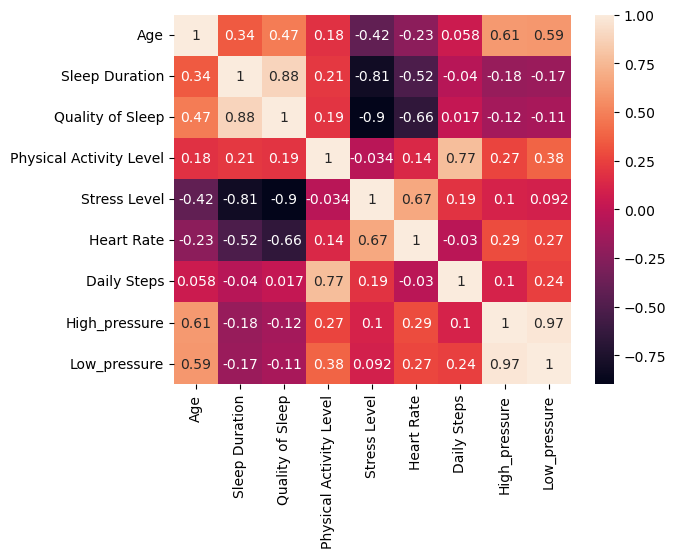

In [11]:
## Find correlation matrix

sns.heatmap(df.corr(numeric_only=True), annot=True)

The correlation matrix provides some interesting insights.

- Stress level and sleep duration show a strong correlation, as do stress level and sleep quality.
- High and low blood pressure are extremely correlated. I will proceed with low_pressure. The use of the harmonic mean might produce a better parameter.

### Plotting against sleep duration

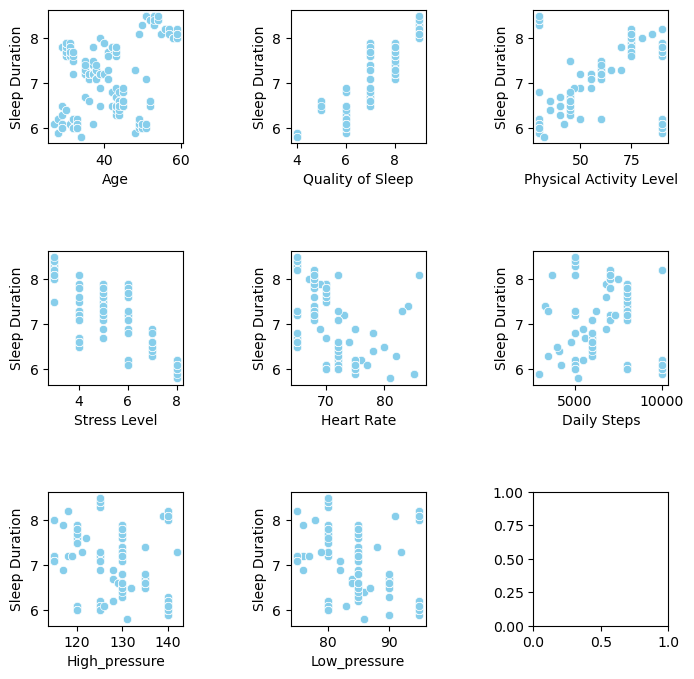

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
plt.subplots_adjust(wspace=0.8, hspace=0.8)

numeric_x = ["Age", "Quality of Sleep", "Physical Activity Level", "Stress Level", "Heart Rate", "Daily Steps", "High_pressure", "Low_pressure"]

for i, cat in enumerate(numeric_x):
    sns.scatterplot(x = cat, y= "Sleep Duration",data=df, color='skyblue', ax=axs[int(i/3), i%3])    

plt.show()

**Results from Scatterplot**

- Physical Activity Level appears linearly dependent but has a significant number of outliers in the left top and right bottom corners. What could be the reason?
- As the heart rate increases, the sleep duration decreases, though we should not jump to conclusions about causality as it's likely the other way around.
- The relationships between most variables and sleep duration appear somewhat linear. However, there's an issue with the graph where dots overlap, resulting in these points being weighted higher.

I will not eliminate any parameters based on these results. Instead, I'll employ a regularization technique when building the model to exclude irrelevant parameters.

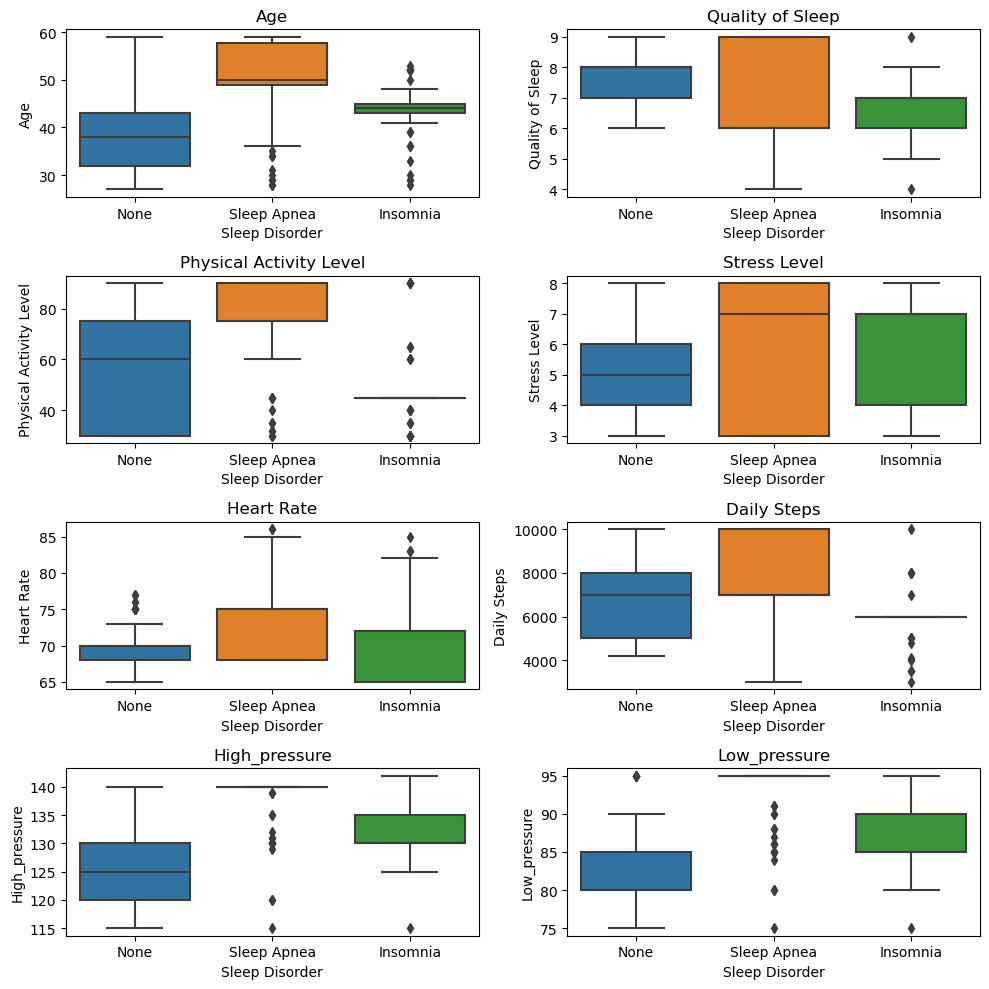

In [13]:
# Create a grid of plots
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
plt.subplots_adjust(wspace=0.8, hspace=0.8)

# Iterate over pairs of parameters

for i, ax in enumerate(axs.flat):
    sns.boxplot(x='Sleep Disorder', y=numeric_x[i], data=df, ax=ax).set_title(numeric_x[i])

plt.tight_layout()
plt.show()


**Results from Boxplots for Different Levels of Sleep Disorders**

- A more noticeable difference seems to exist between Sleep Apnea and None, as compared to the difference between Insomnia and None.
- Insomnia appears to have a higher mean value in each category.
- The most substantial difference seems to be in the Age and Low Blood Pressure parameters.

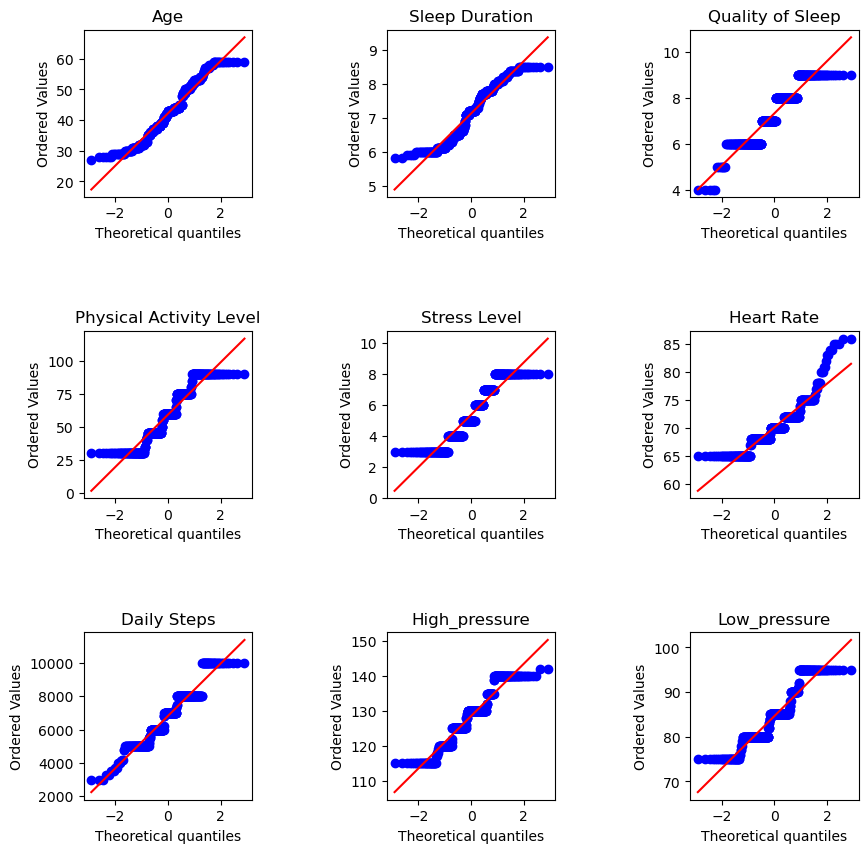

In [14]:
import matplotlib.pyplot as plt
from scipy.stats import probplot

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
plt.subplots_adjust(wspace=0.8, hspace=0.8)

# Iterate over pairs of parameters

for i, ax in enumerate(axs.flat):
    probplot(df[numeric[i]], plot=axs[int(i/3), i%3])
    ax.set_title(numeric[i])

plt.show()

In [15]:
from scipy.stats import shapiro

print("{:<20} {:<20} {:<20} {:<20}".format('Column','Statistics', 'P-Value', 'Result'))
print('-'*80)

for col in numeric:
    stat, p = shapiro(df[col])

    # interpret
    alpha = 0.05
    if p > alpha:
        result = 'seem Gaussian (fail to reject H0)'
    else:
        result = 'not seem Gaussian (reject H0)'

    print("{:<20} {:<20.3f} {:<20.3f} {:<20}".format(col[:18], stat, p, result))


Column               Statistics           P-Value              Result              
--------------------------------------------------------------------------------
Age                  0.958                0.000                not seem Gaussian (reject H0)
Sleep Duration       0.936                0.000                not seem Gaussian (reject H0)
Quality of Sleep     0.894                0.000                not seem Gaussian (reject H0)
Physical Activity    0.899                0.000                not seem Gaussian (reject H0)
Stress Level         0.891                0.000                not seem Gaussian (reject H0)
Heart Rate           0.883                0.000                not seem Gaussian (reject H0)
Daily Steps          0.937                0.000                not seem Gaussian (reject H0)
High_pressure        0.925                0.000                not seem Gaussian (reject H0)
Low_pressure         0.894                0.000                not seem Gaussian (reject H0

#### Results from Normality Test

**QQ-Plot**

Although the QQ-plot appears to indicate a normal distribution, there might be issues due to overlapping data points and a density bias towards certain values.

**Shapiro-Wilk**

Using the Shapiro-Wilk test, none of the parameters appear to follow a normal distribution. While a p-value of 0.0000 seems incorrect, applying the same test to a sample drawn from a normal distribution does suggest that it is a normal sample. There might be issues here with the density of certain data points. Despite these issues, some distributions, such as Age, seem to approximate a normal distribution.

## Analysis of Categorical values



### Analysis in relation to sleep duration

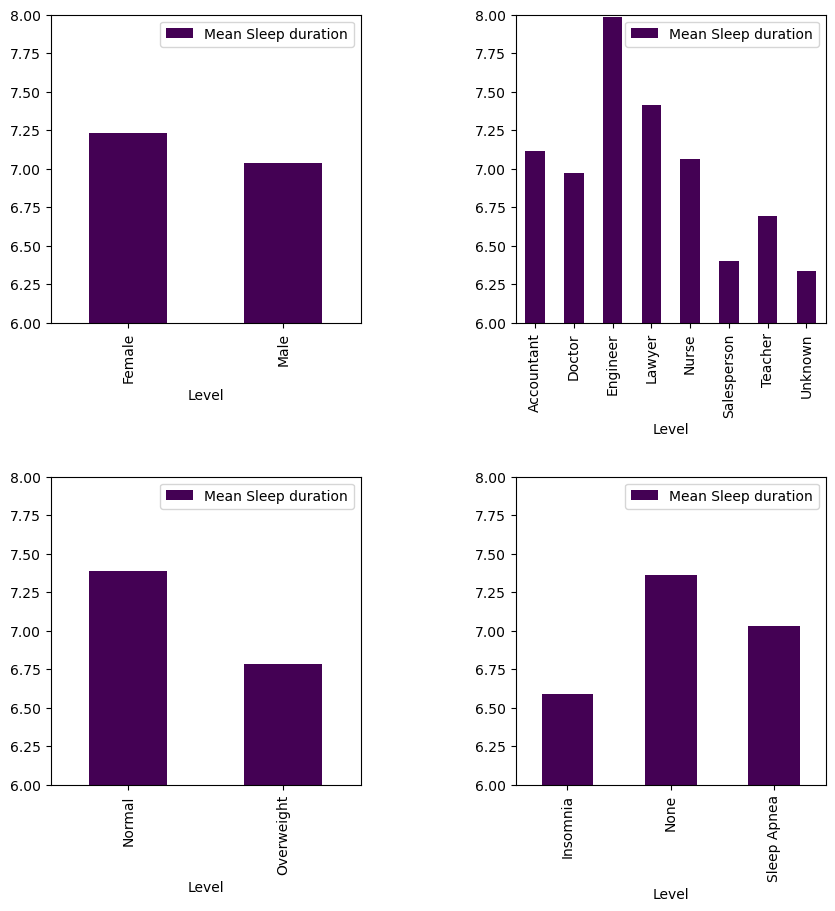

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i,cat in enumerate(categorical):
    mean_values = df.groupby(cat)['Sleep Duration'].mean()
    temp_df = df.isna().sum()
    temp_df = pd.DataFrame(mean_values).reset_index()
    temp_df.columns = ['Level', 'Mean Sleep duration']
    temp_df.plot(kind='bar', x='Level', y='Mean Sleep duration', ax=axs[int(i/2), i%2], colormap='viridis')
    axs[int(i/2), i%2].set_ylim(6,8)

plt.show()

    


**Results from Mean Analysis**

Clear differences appear to exist between different levels. However, an ANOVA test will be performed to determine if these differences are statistically significant.

In [17]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

for col in categorical:
    mod = ols('Q("Sleep Duration") ~ C(Q("{}"))'.format(col), data=df).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print("ANOVA result for column: ", col)
    print(aov_table)
    print("\n")
    


ANOVA result for column:  Gender
                    sum_sq     df         F    PR(>F)
C(Q("Gender"))    3.490392    1.0  5.581156  0.018669
Residual        232.644582  372.0       NaN       NaN


ANOVA result for column:  Occupation
                        sum_sq     df          F        PR(>F)
C(Q("Occupation"))   83.728042    7.0  28.724287  1.703909e-31
Residual            152.406932  366.0        NaN           NaN


ANOVA result for column:  BMI Category
                          sum_sq     df          F        PR(>F)
C(Q("BMI Category"))   33.475890    1.0  61.448176  4.836096e-14
Residual              202.659083  372.0        NaN           NaN


ANOVA result for column:  Sleep Disorder
                            sum_sq     df          F        PR(>F)
C(Q("Sleep Disorder"))   34.661541    2.0  31.913468  1.626151e-13
Residual                201.473432  371.0        NaN           NaN




**Conclusion from ANOVA**

Utilizing an alpha level of 5%, we can conclude that each of the categorical variables is significant, and the means between different classes are not the same with a confidence level of 95% (although performing multiple calculations consecutively might slightly decrease the confidence level). To identify individual differences between specific levels within a category, a Fisher's test could be conducted. However, for this analysis, it's not necessary.

### Analysis in relation to sleep disorder

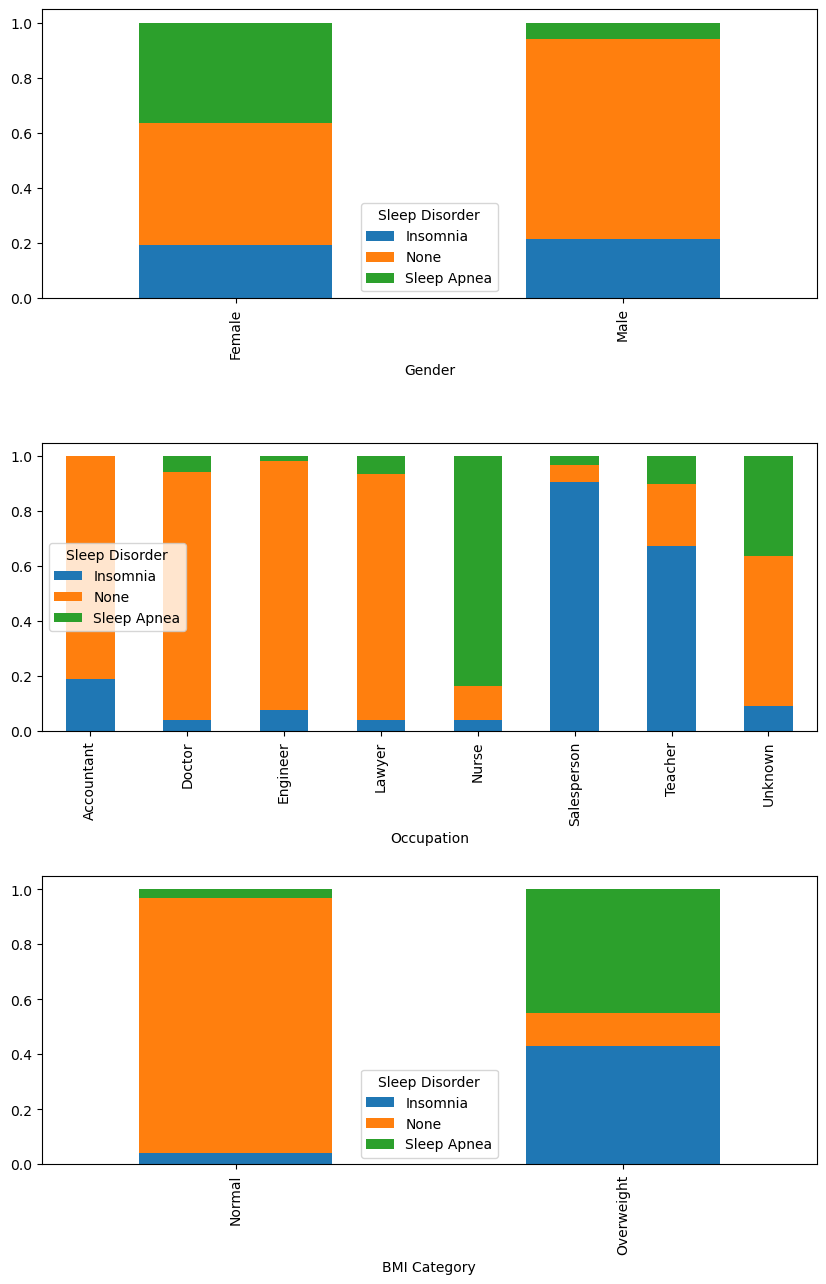

In [18]:


fig, axs = plt.subplots(3, 1, figsize=(10, 15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

categorical_x = ["Gender", "Occupation", "BMI Category"]

for i,cat in enumerate(categorical_x):
    
    counts = (df.groupby([cat])['Sleep Disorder']
                      .value_counts(normalize=True)
                      .unstack())

    counts.plot(kind='bar', stacked=True, ax=axs[i])

**Conclusion from Stacked Bar Plot**

- Sleep apnea and insomnia seems to be more prevalent among females, acording to the dataset.
- Nearly all of the nurses in this dataset suffer from Sleep Apnea, a significant proportion of salespersons and many teachers have insomnia.
- Almost everyone with sleep apnea or insomnia is overweight.

These findings are quite intriguing. The fact that almost everyone working as a nurse has a sleep disorder is unusual. It might be because nurses are more likely to be diagnosed, but that doesn't explain why most salespersons or teachers have insomnia. The same applies to overweight individuals, about 80% of whom have a sleep disorder.

There are many counter-intuitive factors here, which could be due to selection bias. However, if further study is possible, some of these variables could yield the most interesting results, as the data appears very conclusive at this point.

# Summary

## Numerical 

The numerical categories are largely usable as they are, with the sole exception of blood pressure, but a solution for this can be found in the notebook.
- None of the categories align closely enough with the normal distribution for the null hypothesis to be upheld using the Shapiro-Wilk test.
- There are peculiarities with the quality of sleep, stress level, and physical activity level where they seem to be spaced out (possibly due to issues with the questions asked). The same sporadic pattern is observed in blood pressure and steps, which needs further explanation and might have impacted the normality test.
- By using box plots and calculating means for individuals with and without sleep disorders, we find that the means do differ, though the significance of these differences has not been tested. 

## Categorical 

The categorical parameters are also well-structured, with the only tweak being the consolidation of occupations with a low sample size into an unknown level.

- Using the ANOVA test to assess the significance on sleep duration, we find all categorical parameters to be significant.
- By employing a stacked bar plot, we find that specifically occupation and weight are quite "skewed", with almost all instances of disorders falling into one level. This will be discussed in the problems section.

## Problems

### Selection Bias

My findings in the categorical parameters suggest that 90% of nurses have some sleep disorder while doctors and engineers have barely any disorders. This discrepancy hints at some selection bias in the data, which might also explain why none of the numerical values come from a normal distribution. There are also extreme differences between obese and normal BMI categories, a disparity that might not intuitively be this large.

### Self-Assessment Bias

If the target group has been asked to rate themselves on their stress levels, their assessments could introduce bias. For instance, there are instances where cancer patients rate their diet as worse than non-cancer patients, despite having the same diet. The same issue could arise with self-assessment of physical activity levels. This could completely undermine any predictability of disorders.

### Correlation

Concerning selection bias, any conclusions drawn about individuals with sleep disorders could equally be interpreted as observations about overweight individuals. This, along with the correlation to occupation, reduces the explanatory power of our analysis.

## Conclusion

I hope you found this analysis helpful. The dataset is excellent in quality, but certain considerations need to be made. I recommend comparing this data with similar datasets to pinpoint potential biases, or even complementing it with another dataset to enhance the analysis. Furthermore, the data collection method piques my interest due to the potential biases hinted at in the analysis.

## Final Words

Thank you for reading through this analysis. An upvote would make my day, and all feedback is highly appreciated.